<a href="https://colab.research.google.com/github/WoogiWooks/DLCV_New/blob/main/4_OpenCV_DNN_%EC%9D%B4%EC%9A%A9%ED%95%9C_Faster_RCNN_%EA%B5%AC%ED%98%84.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **OpenCV의 DNN 이용한 Object Detection 구현**
* OpenCV 기반에서 COCO 데이터셋을 사용시
  * Tensorflow Faster RCNN 모델 => 미싱 id 포함 0~90까지
  * Tensorflow SSD 모델 로드 => 미싱 id 포함 1~91까지
  * Tensorflow Mask RCNN 모델 로드 => 미싱 id 포함 0~90까지
  * Darknet YOLO 모델 로드 => 미싱 id 제외 0~79까지

## **1. 이미지**

In [ ]:
!pwd

/content


In [ ]:
!mkdir /content/data
!wget -O ./data/beatles01.jpg https://raw.githubusercontent.com/chulminkw/DLCV/master/data/image/beatles01.jpg

--2022-01-23 06:58:31--  https://raw.githubusercontent.com/chulminkw/DLCV/master/data/image/beatles01.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 383118 (374K) [image/jpeg]
Saving to: ‘./data/beatles01.jpg’

./data/beatles01.jp 100%[===================>] 374.14K  --.-KB/s    in 0.02s   

2022-01-23 06:58:31 (15.3 MB/s) - ‘./data/beatles01.jpg’ saved [383118/383118]



image shape: (633, 806, 3)


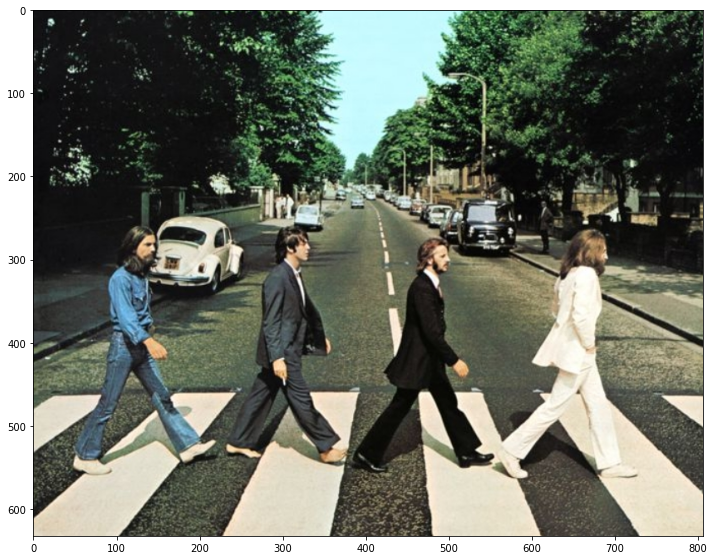

In [ ]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

img = cv2.imread('./data/beatles01.jpg')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

print('image shape:', img.shape)
plt.figure(figsize=(12, 12))
plt.imshow(img_rgb)

In [ ]:
# pretrained 된 모델과 환경설정 파일을 다운로드
# frozen 이란 weight 가 더 이상 업데이트 되지 않는 것

!mkdir ./pretrained
!wget -O ./pretrained/faster_rcnn_resnet50_coco_2018_01_28.tar.gz http://download.tensorflow.org/models/object_detection/faster_rcnn_resnet50_coco_2018_01_28.tar.gz
!wget -O ./pretrained/config_graph.pbtxt https://raw.githubusercontent.com/opencv/opencv_extra/master/testdata/dnn/faster_rcnn_resnet50_coco_2018_01_28.pbtxt

--2022-01-23 07:02:32--  http://download.tensorflow.org/models/object_detection/faster_rcnn_resnet50_coco_2018_01_28.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 74.125.197.128, 2607:f8b0:400e:c01::80
Connecting to download.tensorflow.org (download.tensorflow.org)|74.125.197.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 381355771 (364M) [application/x-tar]
Saving to: ‘./pretrained/faster_rcnn_resnet50_coco_2018_01_28.tar.gz’

./pretrained/faster 100%[===================>] 363.69M   259MB/s    in 1.4s    

2022-01-23 07:02:34 (259 MB/s) - ‘./pretrained/faster_rcnn_resnet50_coco_2018_01_28.tar.gz’ saved [381355771/381355771]

--2022-01-23 07:02:34--  https://raw.githubusercontent.com/opencv/opencv_extra/master/testdata/dnn/faster_rcnn_resnet50_coco_2018_01_28.pbtxt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.git

In [ ]:
!tar -xvf ./pretrained/faster*.tar.gz -C ./pretrained 
# -C 는 디렉토리 지정

faster_rcnn_resnet50_coco_2018_01_28/
faster_rcnn_resnet50_coco_2018_01_28/model.ckpt.index
faster_rcnn_resnet50_coco_2018_01_28/checkpoint
faster_rcnn_resnet50_coco_2018_01_28/pipeline.config
faster_rcnn_resnet50_coco_2018_01_28/model.ckpt.data-00000-of-00001
faster_rcnn_resnet50_coco_2018_01_28/model.ckpt.meta
faster_rcnn_resnet50_coco_2018_01_28/saved_model/
faster_rcnn_resnet50_coco_2018_01_28/saved_model/saved_model.pb
faster_rcnn_resnet50_coco_2018_01_28/saved_model/variables/
faster_rcnn_resnet50_coco_2018_01_28/frozen_inference_graph.pb


In [ ]:
cv_net = cv2.dnn.readNetFromTensorflow('./pretrained/faster_rcnn_resnet50_coco_2018_01_28/frozen_inference_graph.pb', 
                                     './pretrained/config_graph.pbtxt')

In [ ]:
# OpenCV Tensorflow Faster-RCNN용
labels_to_names_0 = {0:'person',1:'bicycle',2:'car',3:'motorcycle',4:'airplane',5:'bus',6:'train',7:'truck',8:'boat',9:'traffic light',
                    10:'fire hydrant',11:'street sign',12:'stop sign',13:'parking meter',14:'bench',15:'bird',16:'cat',17:'dog',18:'horse',19:'sheep',
                    20:'cow',21:'elephant',22:'bear',23:'zebra',24:'giraffe',25:'hat',26:'backpack',27:'umbrella',28:'shoe',29:'eye glasses',
                    30:'handbag',31:'tie',32:'suitcase',33:'frisbee',34:'skis',35:'snowboard',36:'sports ball',37:'kite',38:'baseball bat',39:'baseball glove',
                    40:'skateboard',41:'surfboard',42:'tennis racket',43:'bottle',44:'plate',45:'wine glass',46:'cup',47:'fork',48:'knife',49:'spoon',
                    50:'bowl',51:'banana',52:'apple',53:'sandwich',54:'orange',55:'broccoli',56:'carrot',57:'hot dog',58:'pizza',59:'donut',
                    60:'cake',61:'chair',62:'couch',63:'potted plant',64:'bed',65:'mirror',66:'dining table',67:'window',68:'desk',69:'toilet',
                    70:'door',71:'tv',72:'laptop',73:'mouse',74:'remote',75:'keyboard',76:'cell phone',77:'microwave',78:'oven',79:'toaster',
                    80:'sink',81:'refrigerator',82:'blender',83:'book',84:'clock',85:'vase',86:'scissors',87:'teddy bear',88:'hair drier',89:'toothbrush',
                    90:'hair brush'}

In [ ]:
img.shape  
# 뒤에 setup 에서 Convert 진행되므로 BGR image로 진행

(633, 806, 3)

(1, 1, 100, 7)
person: 0.9998
person: 0.9996
person: 0.9993
person: 0.9970
person: 0.8995
car: 0.8922
car: 0.7602
car: 0.7415
car: 0.6930
car: 0.6918
car: 0.6896
car: 0.6717
car: 0.6521
car: 0.5730
car: 0.5679
car: 0.5261
car: 0.5012


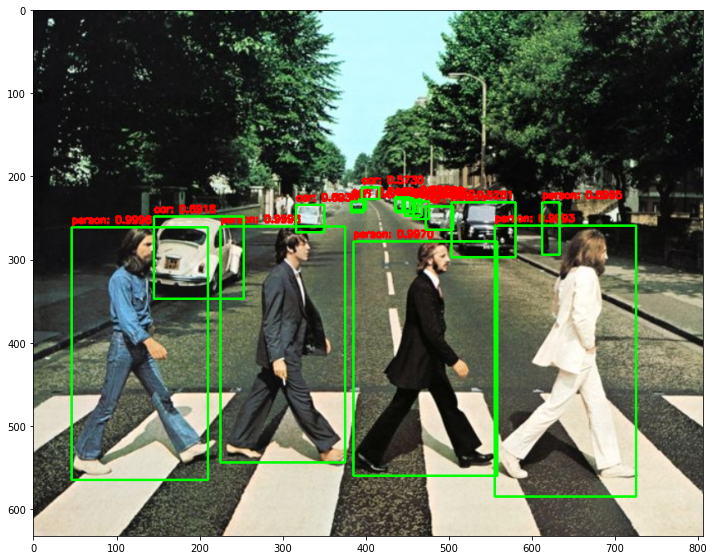

In [ ]:
# 원본 이미지가 Faster RCNN기반 네트웍으로 입력 시 resize되며 이후 0과1 사이의 스케일링 된 값으로 원본 이미지 내에 위치가 표기됨. 
# 스케일링된 값으로 bounding box 위치가 예측 되므로 이를 다시 복원하기 위해 원본 이미지 shape정보 필요
rows = img.shape[0]
cols = img.shape[1]
# cv2의 rectangle()은 인자로 들어온 이미지 배열에 직접 사각형을 업데이트 하므로 그림 표현을 위한 별도의 이미지 배열 생성. 
draw_img = img.copy()

# 원본 이미지 배열 BGR을 RGB로 변환하여 배열 입력
# Tensorflow Faster RCNN은 마지막 classification layer가 Dense가 아니여서 size를 고정할 필요는 없음.  
cv_net.setInput(cv2.dnn.blobFromImage(img, swapRB=True, crop=False))

# Object Detection 수행하여 결과를 cv_out으로 반환
################### cv_out의 결과물 = (1, 1, Detect된 Object 갯수, 7) ###################
################### 7에는 (None Mean, Class ID, Confidence Level, x좌표, y좌표, h, w) ###################
################### 좌표값은 0-1 사이의 값으로 스케일링된 값으로 나옴 ###################
cv_out = cv_net.forward()
print(cv_out.shape)

# bounding box의 테두리와 caption 글자색 지정
green_color=(0, 255, 0)
red_color=(0, 0, 255)

# detected 된 object들을 iteration 하면서 정보 추출
# 100번 루프가 돌게됨
for detection in cv_out[0,0,:,:]:
    score = float(detection[2])
    class_id = int(detection[1])
    # detected된 object들의 score가 0.5 이상만 추출
    if score > 0.5:
        # detected된 object들은 scale된 기준으로 예측되었으므로 다시 원본 이미지 비율로 계산
        left = detection[3] * cols
        top = detection[4] * rows
        right = detection[5] * cols
        bottom = detection[6] * rows
        # labels_to_names_seq 딕셔너리로 class_id값을 클래스명으로 변경.
        caption = "{}: {:.4f}".format(labels_to_names_0[class_id], score)
        print(caption)
        #cv2.rectangle()은 인자로 들어온 draw_img에 사각형을 그림. 위치 인자는 반드시 정수형.
        cv2.rectangle(draw_img, (int(left), int(top)), (int(right), int(bottom)), color=green_color, thickness=2)
        cv2.putText(draw_img, caption, (int(left), int(top - 5)), cv2.FONT_HERSHEY_SIMPLEX, 0.4, red_color, 2)

img_rgb = cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12, 12))
plt.imshow(img_rgb)

# shape의 100은 img에서 Detecting된 Object 갯수, 

In [ ]:
################### cv_out의 결과물 = (1, 1, Detect된 Object 갯수, 7) ###################
################### 7에는 (None Mean, Class ID, Confidence Level, x좌표, y좌표, h, w) ###################
################### 좌표값은 0-1 사이의 값으로 스케일링된 값으로 나옴 ###################

cv_out

array([[[[0.00000000e+00, 0.00000000e+00, 9.99780715e-01,
          2.80248284e-01, 4.11070347e-01, 4.66062069e-01,
          8.59829903e-01],
         [0.00000000e+00, 0.00000000e+00, 9.99588192e-01,
          5.82912564e-02, 4.13466036e-01, 2.61212528e-01,
          8.93701494e-01],
         [0.00000000e+00, 0.00000000e+00, 9.99259293e-01,
          6.89431846e-01, 4.10281926e-01, 8.99752796e-01,
          9.24375653e-01],
         [0.00000000e+00, 0.00000000e+00, 9.96988714e-01,
          4.78255421e-01, 4.39302981e-01, 6.92748547e-01,
          8.84738147e-01],
         [0.00000000e+00, 0.00000000e+00, 8.99451733e-01,
          7.59500206e-01, 3.65392357e-01, 7.86593020e-01,
          4.65826124e-01],
         [0.00000000e+00, 0.00000000e+00, 2.80753374e-01,
          7.87774742e-01, 3.81029904e-01, 8.25374067e-01,
          4.47248816e-01],
         [0.00000000e+00, 0.00000000e+00, 1.82083517e-01,
          3.73442054e-01, 3.48522216e-01, 3.83972704e-01,
          4.01509136e-01],

In [ ]:
# 단일 이미지 Object Detection 에 대한 함수 생성

import time

def get_detected_img(cv_net, img_array, score_threshold, use_copied_array=True, is_print=True):
    
    rows = img_array.shape[0]
    cols = img_array.shape[1]
    
    draw_img = None
    if use_copied_array:
        draw_img = img_array.copy()
    else:
        draw_img = img_array
    
    cv_net.setInput(cv2.dnn.blobFromImage(img_array, swapRB=True, crop=False))
    
    start = time.time()
    cv_out = cv_net.forward()
    
    green_color=(0, 255, 0)
    red_color=(0, 0, 255)

    # detected 된 object들을 iteration 하면서 정보 추출
    for detection in cv_out[0,0,:,:]:
        score = float(detection[2])
        class_id = int(detection[1])
        # detected된 object들의 score가 함수 인자로 들어온 score_threshold 이상만 추출
        if score > score_threshold:
            # detected된 object들은 scale된 기준으로 예측되었으므로 다시 원본 이미지 비율로 계산
            left = detection[3] * cols
            top = detection[4] * rows
            right = detection[5] * cols
            bottom = detection[6] * rows
            # labels_to_names 딕셔너리로 class_id값을 클래스명으로 변경. opencv에서는 class_id + 1로 매핑해야함.
            caption = "{}: {:.4f}".format(labels_to_names_0[class_id], score)
            print(caption)
            #cv2.rectangle()은 인자로 들어온 draw_img에 사각형을 그림. 위치 인자는 반드시 정수형.
            cv2.rectangle(draw_img, (int(left), int(top)), (int(right), int(bottom)), color=green_color, thickness=2)
            cv2.putText(draw_img, caption, (int(left), int(top - 5)), cv2.FONT_HERSHEY_SIMPLEX, 0.4, red_color, 1)
    if is_print:
        print('Detection 수행시간:',round(time.time() - start, 2),"초")

    return draw_img

In [ ]:
!wget -O ./data/baseball01.jpg https://raw.githubusercontent.com/chulminkw/DLCV/master/data/image/baseball01.jpg

--2022-01-23 07:31:28--  https://raw.githubusercontent.com/chulminkw/DLCV/master/data/image/baseball01.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 76279 (74K) [image/jpeg]
Saving to: ‘./data/baseball01.jpg’

./data/baseball01.j 100%[===================>]  74.49K  --.-KB/s    in 0.008s  

2022-01-23 07:31:28 (8.66 MB/s) - ‘./data/baseball01.jpg’ saved [76279/76279]



image shape: (476, 735, 3)
person: 0.9998
person: 0.9997
person: 0.9977
sports ball: 0.8867
baseball bat: 0.8420
baseball glove: 0.9815
Detection 수행시간: 7.68 초


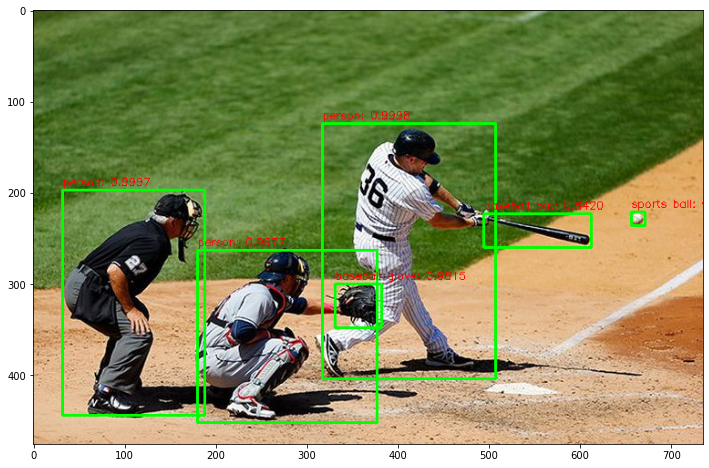

In [ ]:
img = cv2.imread('./data/baseball01.jpg')
print('image shape:', img.shape)

# tensorflow inference 모델 로딩
cv_net = cv2.dnn.readNetFromTensorflow('./pretrained/faster_rcnn_resnet50_coco_2018_01_28/frozen_inference_graph.pb', 
                                     './pretrained/config_graph.pbtxt')
# Object Detetion 수행 후 시각화 
draw_img = get_detected_img(cv_net, img, score_threshold=0.5, use_copied_array=True, is_print=True)

img_rgb = cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12, 12))
plt.imshow(img_rgb)

## **2. 비디오**
* OpenCV 의 VideoCapture 사용하여 Frame별로 Capture 가능
* Frame 을 돌면서 이미지 Detection 이 수행됨

In [ ]:
!wget -O ./data/Jonh_Wick_small.mp4 https://github.com/chulminkw/DLCV/blob/master/data/video/John_Wick_small.mp4?raw=true

--2022-01-23 07:41:28--  https://github.com/chulminkw/DLCV/blob/master/data/video/John_Wick_small.mp4?raw=true
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/chulminkw/DLCV/raw/master/data/video/John_Wick_small.mp4 [following]
--2022-01-23 07:41:28--  https://github.com/chulminkw/DLCV/raw/master/data/video/John_Wick_small.mp4
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/chulminkw/DLCV/master/data/video/John_Wick_small.mp4 [following]
--2022-01-23 07:41:28--  https://raw.githubusercontent.com/chulminkw/DLCV/master/data/video/John_Wick_small.mp4
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.

In [ ]:
video_input_path = '/content/data/Jonh_Wick_small.mp4'

cap = cv2.VideoCapture(video_input_path)
frame_cnt = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print('총 Frame 갯수:', frame_cnt)

총 Frame 갯수: 58


In [ ]:
video_input_path = '/content/data/Jonh_Wick_small.mp4'
video_output_path = './data/John_Wick_small_OD.mp4'

cap = cv2.VideoCapture(video_input_path)

# VideoWriter를 어떤 코덱을 사용하여 진행할 것인지
codec = cv2.VideoWriter_fourcc(*'XVID')

vid_size = (round(cap.get(cv2.CAP_PROP_FRAME_WIDTH)),round(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))) 
vid_fps = cap.get(cv2.CAP_PROP_FPS )
    
vid_writer = cv2.VideoWriter(video_output_path, codec, vid_fps, vid_size) 

# img.copy와 같은 과정임, 내가 설정한 값의 Video를 생성
# input video를 이름과 codec, fps, size 설정해서 새로운 output video 생성
# 원본 이미지와 다른 사이즈를 넣어주면 다른 사이즈의 비디오가 저장되는 것임

frame_cnt = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print('총 Frame 갯수:', frame_cnt)

총 Frame 갯수: 58


In [ ]:
# bounding box의 테두리와 caption 글자색 지정
green_color=(0, 255, 0)
red_color=(0, 0, 255)

while True:

    hasFrame, img_frame = cap.read()
    if not hasFrame:
        print('더 이상 처리할 frame이 없습니다.')
        break

    rows = img_frame.shape[0]
    cols = img_frame.shape[1]
    # 원본 이미지 배열 BGR을 RGB로 변환하여 배열 입력
    cv_net.setInput(cv2.dnn.blobFromImage(img_frame,  swapRB=True, crop=False))
    
    start= time.time()
    # Object Detection 수행하여 결과를 cv_out으로 반환 
    cv_out = cv_net.forward()
    frame_index = 0
    # detected 된 object들을 iteration 하면서 정보 추출
    for detection in cv_out[0,0,:,:]:
        score = float(detection[2])
        class_id = int(detection[1])
        # detected된 object들의 score가 0.5 이상만 추출
        if score > 0.5:
            # detected된 object들은 scale된 기준으로 예측되었으므로 다시 원본 이미지 비율로 계산
            left = detection[3] * cols
            top = detection[4] * rows
            right = detection[5] * cols
            bottom = detection[6] * rows
            # labels_to_names_0딕셔너리로 class_id값을 클래스명으로 변경.
            caption = "{}: {:.4f}".format(labels_to_names_0[class_id], score)
            #print(class_id, caption)
            #cv2.rectangle()은 인자로 들어온 draw_img에 사각형을 그림. 위치 인자는 반드시 정수형.
            cv2.rectangle(img_frame, (int(left), int(top)), (int(right), int(bottom)), color=green_color, thickness=2)
            cv2.putText(img_frame, caption, (int(left), int(top - 5)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, red_color, 1)
    print('Detection 수행 시간:', round(time.time()-start, 2),'초')
    vid_writer.write(img_frame)
# end of while loop

vid_writer.release()
cap.release()   

Detection 수행 시간: 8.01 초
Detection 수행 시간: 7.82 초
Detection 수행 시간: 7.81 초
Detection 수행 시간: 7.81 초
Detection 수행 시간: 7.83 초
Detection 수행 시간: 7.85 초
Detection 수행 시간: 7.78 초
Detection 수행 시간: 7.79 초
Detection 수행 시간: 7.83 초
Detection 수행 시간: 7.77 초
Detection 수행 시간: 7.81 초
Detection 수행 시간: 7.79 초
Detection 수행 시간: 7.88 초
Detection 수행 시간: 7.8 초
Detection 수행 시간: 7.81 초
Detection 수행 시간: 7.81 초
Detection 수행 시간: 7.87 초
Detection 수행 시간: 7.87 초
Detection 수행 시간: 7.8 초
Detection 수행 시간: 7.8 초
Detection 수행 시간: 7.88 초
Detection 수행 시간: 7.82 초
Detection 수행 시간: 7.75 초
Detection 수행 시간: 7.76 초
Detection 수행 시간: 7.75 초
Detection 수행 시간: 7.8 초
Detection 수행 시간: 7.75 초
Detection 수행 시간: 7.82 초
Detection 수행 시간: 7.8 초
Detection 수행 시간: 7.86 초
Detection 수행 시간: 7.84 초
Detection 수행 시간: 7.93 초
Detection 수행 시간: 7.87 초
Detection 수행 시간: 7.83 초
Detection 수행 시간: 7.83 초
Detection 수행 시간: 7.88 초
Detection 수행 시간: 7.81 초
Detection 수행 시간: 7.83 초
Detection 수행 시간: 7.86 초
Detection 수행 시간: 7.81 초
Detection 수행 시간: 7.8 초
Detection 수행 시간: 7.83 

In [ ]:
# Video Object Detection 위한 함수 생성
# 앞서 만든 단일 이미지 대상 함수를 활용

def do_detected_video(cv_net, input_path, output_path, score_threshold, is_print):
    
    cap = cv2.VideoCapture(input_path)

    codec = cv2.VideoWriter_fourcc(*'XVID')

    vid_size = (round(cap.get(cv2.CAP_PROP_FRAME_WIDTH)),round(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))
    vid_fps = cap.get(cv2.CAP_PROP_FPS)

    vid_writer = cv2.VideoWriter(output_path, codec, vid_fps, vid_size) 

    frame_cnt = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    print('총 Frame 갯수:', frame_cnt)

    green_color=(0, 255, 0)
    red_color=(0, 0, 255)
    while True:
        hasFrame, img_frame = cap.read()
        if not hasFrame:
            print('더 이상 처리할 frame이 없습니다.')
            break
        
        img_frame = get_detected_img(cv_net, img_frame, score_threshold=score_threshold, use_copied_array=False, is_print=is_print)
        
        vid_writer.write(img_frame)
    # end of while loop

    vid_writer.release()
    cap.release()